### Example on Echo State Networks (ESNs)

This notebook covers the first systematic view an basic ESNs.

* Set up everything manually. But use functional form for preparing inputs, training ESN and prediction.
* Here we use similar input length for all input samples.
* Play with hyperparameters, targets (1d, 2d,.., 10d) and use multi-reservoirs with lagged input series.
* ESNs will be applied on some timeseries of Amazon stock prices (closing values) obtained from [Yahoo finance](https://de.finance.yahoo.com/quote/AMZN/history?p=AMZN), timespan 2010-01-04 to 2021-12-31.


Partly following [tutorial on ESNs](https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4) and [review paper on ESNs](https://arxiv.org/abs/2012.02974).

### Technical setup and data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read dataset amazon.txt, absolute values:
data_abs = open("../data/amazon_2010_2021_close.txt").read().split()
data_abs = np.array(data_abs).astype('float64')

### Define functions

* split_data
* trainESN
* predESN
* rel_to_abs

In [138]:
### Define function to split data:

## Function input: 
# Feed timeseries with absolute values.

## Parameters:
# input_length (int): timesteps per input sample
# target_length (int): number of steps ahead to predict
# time_lag (int): Necessary when creating inputs for multi-reservoir ESN, having timelag 0,1,2,... days between
#                 input and target.
# train_val_split ([0,1]): rel. amount of input samples used for training
# scaled_YN (True/False):if True, scale inputs and targets to [0,1] applying min/max scaling 
#                        according to min/max obtained from only train inputs
# verbose (True/False)): if True, print shapes of function input and output

## Function output:
# Returns arrays (samples, timesteps, timelag) train_input and val_input as rel. changes.
# Returns series (samples) train_target and val_target as rel. changes.
# Returns train_min and train_max, used for scaling, set to ZERO, if scaled_YN=False.


def split_data(data, input_length, target_length, time_lag=0, 
               train_val_split=0.8, binary_YN=False, scaled_YN=False,
               verbose=True):
    
    # Convert abs. data to rel. change values.
    data_rel_chg = (data[1:] - data[:-1]) / data[:-1]
     
    # Split data_rel_chg according to desired input_length, save series in list X.
    # End up with (len(data_rel_chg) - input_length + 1) samples.
    X = list()
    for i in range(len(data_rel_chg) - input_length + 1):
        sample = data_rel_chg[i:i+input_length]
        X.append(sample)
    
    # Convert X to np.array.
    X = np.array(X)
    
    # Cut the last target_length samples to make sure, we have a target for each input sample.
    X = X[:-target_length]
        
    # Create rel. change targets from abs. values. Take desired target_length into account. Store in Y.
    Y = (data[target_length:] - data[:-target_length]) / data[:-target_length]
    
    # Cut the first input_length targets, since we don't have input samples for these targets.
    # And cut another time_lag targets upfront, to have identical dimensions for each time_lag slice later on.
    Y = Y[input_length + time_lag:]
    
    # Now take care of desired time_lag.
    # lag=0 means to keep original input samples, but still need to reshape to have lag as third dimension.
    # And leave out the first time_lag input samples to end up with the same dimensions for all lags.    
    X_out = np.reshape(X[time_lag:], (X.shape[0] - time_lag, X.shape[1], 1))
    
    # lag>0 (loop over j) means to leave out the first (time_lag - j) input series and last j input series, 
    # but keep the target fixed! And reshape to have lag as third dimension.
    # Note: Loop starts with j=0, hence need j+1
    for j in range(time_lag):
        X_temp = np.reshape(X[time_lag-(j+1):-(j+1)], (X.shape[0] - time_lag, X.shape[1], 1))
        X_out = np.concatenate((X_out, X_temp), axis=2)
    
    # re-assign obtained X_out to X
    X = X_out    
    
    
    # Split inputs and targets into train and validation data according to train_val_split
    n_train = int(len(X) * train_val_split)
    
    train_input = X[:n_train]
    val_input = X[n_train:]
    train_target = Y[:n_train]
    val_target = Y[n_train:]
  
    # Optionally scale train and validation inputs and targets to [0,1] 
    # according to min/max obtained from train inputs.
    # Initialize train_min and _max to zero, to have return values even if no scaling is desired.
    train_min = 0
    train_max = 0
    if scaled_YN:
        train_min = np.min(train_input)
        train_max = np.max(train_input)

        # scale input values and targets, according to min/min of ONLY train inputs:
        # substract min and divide by (max - min)
        train_input = (train_input - train_min) / (train_max - train_min)
        val_input = (val_input - train_min) / (train_max - train_min)
        train_target = (train_target - train_min) / (train_max - train_min)
        val_target = (val_target - train_min) / (train_max - train_min)

    # Optionally print dimensions
    if verbose:
        print("raw data shape: ", data.shape)
        print("train_input shape: ", train_input.shape)
        print("val_input shape: ", val_input.shape)
        print("train_target shape: ", train_target.shape)
        print("val_target shape: ", val_target.shape)
        print("train_min: ", train_min)
        print("train_max: ", train_max)
        
    #return values
    return train_input, val_input, train_target, val_target, train_min, train_max    

In [158]:
### Define function to train basic ESN:

## Function input: 
# Feed timeseries with relative change values: train_input and train_target with
# dimensions (num samples, num timesteps) and (num samples), respectively.

## Parameters:
# n_res (int): number of reservoir units
# sparsity ([0,1]): Sparsity of connections in reservoir
# spectral_rad (real>0): Spectral radius for initializing reservoir weights.
# w_in_lim (real>0): Parameter for initializing input weights.
# activation ('tanh', 'sigmoid'): Specify function for transition of reservoir states.
# verbose (True/False)): if True, print shapes of function input and output

## Function output:
# Returns array containing input weights W_in (n_res, 1).
# Returns array containing reservoir weights W_res (n_res, n_res).
# Returns array containing trained output weights W_out (1, n_res).


def trainESN(train_input, train_target, n_res, sparsity=0.2, spectral_rad=1.2, w_in_lim=1.0, 
             activation='tanh', verbose=True):
    
    # Get number of samples (n_samples) and input length (T) from train_input
    n_samples = train_input.shape[0]
    T = train_input.shape[1]

    ## initialize W_in from uniform distribution in [-w_in_lim, w_in_lim]
    W_in = np.random.uniform(low=-w_in_lim, high=w_in_lim, size=(n_res,1))
  
    ## initialize W_res

    # Need temporary matrix W_temp to implement sparsity manually
    W_temp = np.random.uniform(low=0, high=1, size=(n_res,n_res))
    W_sparse = W_temp <= sparsity

    # Then initialize W_full from uniform distribution in [-1,1]
    W_full = np.random.uniform(low=-1.0, high=1.0, size=(n_res,n_res))

    # Now apply sparsity to W_full
    W = W_sparse * W_full

    # get largest Eigenvalue of W
    ev_max = np.max(np.real(np.linalg.eigvals(W)))

    # finally set up W_res
    W_res = spectral_rad * W / ev_max

    ## Use X to store all n_res final reservoir states after T input steps
    ## for all n_samples train inputs, use specified activation function.
    
    # initialize X (n_res x n_samples)
    X = np.zeros((n_res,n_samples))
    
    # Loop over n_samples    
    for i in range(n_samples):
        
        # Loop over timesteps in current sample
        for j in range(T):
            
            # If desired activation function is 'tanh':
            if activation=='tanh':
                # first input timestep needs special treatment, since reservoir state is not yet initialized
                if j == 0:
                    X[:,i:i+1] = np.tanh(W_in * train_input[i,j])
                elif j > 0:
                    X[:,i:i+1] = np.tanh(W_in * train_input[i,j] + np.reshape(np.matmul(W_res, X[:,i:i+1]),(n_res,1)))
            #not yet implemented: 'sigmoid' activation
            #elif activation=='sigmoid':          
                
    ## Get output weights W_out from closed form solution

    # First need pseudo-inverse of X, since X is usually not a square matrix
    X_inv = np.linalg.pinv(X)

    # then need to reshape train_target
    train_target = np.reshape(train_target, (1,n_samples))

    # then get output weights
    W_out = np.matmul(train_target, X_inv)

    # Optionally print dimensions
    if verbose:
        print("train_input shape: ", train_input.shape)
        print("train_target shape: ", train_target.shape)        
    print("W_in shape: ", W_in.shape)
    print("W_out shape: ", W_out.shape)
    print("W_res shape: ", W_res.shape)
    print("W_res max: ", np.round(np.max(W_res),3))
    print("W_res sparsity: ", np.round(sum(sum(W_res != 0)) / (n_res**2), 3))
    
    # return values
    return W_in, W_res, W_out

In [199]:
### Define function to get ESN predictions and evaluation metrics on validation data:

## Function input: 
# Feed weight matrices W_in, W_res and W_out from traines ESN.
# Feed validation data with relative change values: val_input and val_target with
# dimensions (num samples, num timesteps) and (num samples), respectively.

## Parameters:
# activation ('tanh', 'sigmoid'): Specify function for transition of reservoir states. (Shoud be the same as in training!)
# scaled_YN (True/False): Flags if we work have scaled inputs and targets. This is important to know, since  
#                         calculating the accuracy requires un-scaled rel. change values.
# train_min / train_max: If we have scaled inputs, we need min and max values used for scaling.
# verbose (True/False)): if True, print shapes of function input and output plus evaluation metrics

## Function output:
# Returns array containing true targets val_target (num samples), as un-scaled rel. change values.
# Returns array containing predictions val_pred (num samples), as un-scaled rel. change values.
# Returns accuracy as amount of correctly predicted up/down movements.
# Returns mean-absolute-error for deviation of predicted values from true targets.

def predESN(W_in, W_res, W_out, val_input, val_target, activation='tanh', scaled_YN=False, 
            train_min=0.0, train_max=0.0, verbose=True):
    
    # Get number of reservoir units (n_res), number of samples (n_samples) and input length (T) from inputs
    n_res = len(W_res)
    n_samples = val_input.shape[0]
    T = val_input.shape[1]
    
    ## Use X to store all n_res final reservoir states after T input steps
    ## for all n_samples validation inputs, use specified activation function.
    
    # initialize X (n_res x n_samples)
    X = np.zeros((n_res,n_samples))
    
    # Loop over n_samples    
    for i in range(n_samples):
        
        # Loop over timesteps in current sample
        for j in range(T):
            
            # If desired activation function is 'tanh':
            if activation=='tanh':
                # first input timestep needs special treatment, since reservoir state is not yet initialized
                if j == 0:
                    X[:,i:i+1] = np.tanh(W_in * val_input[i,j])
                elif j > 0:
                    X[:,i:i+1] = np.tanh(W_in * val_input[i,j] + np.reshape(np.matmul(W_res, X[:,i:i+1]),(n_res,1)))
            #not yet implemented: 'sigmoid' activation
            #elif activation=='sigmoid':          
                
    # Get predicted output from trained W_out and final reservoir states for all validation inputs.
    # Note: val_pred comes with shape (1, num samples), need to get rid of first dimension.
    val_pred = np.matmul(W_out, X)[0]
    
    # Optionally re-scale target and prediction before calculating accuracy on un-scaled rel. change values.
    if scaled_YN:
        val_target = val_target * (train_max - train_min) + train_min
        val_pred = val_pred  * (train_max - train_min) + train_min
              
    ## Evaluate ESN prediction
    
    # check balance in up/down movements of validation data
    val_balance = np.round(sum(val_target>=0) / len(val_target), 3)
    
    # get prediction accuracy from rel. change prediction
    accuracy = np.round(sum(np.sign(val_target) == np.sign(val_pred)) / len(val_target), 3)

    # get mean-absolute-error for deviation of predicted values from true targets
    mae = np.round(sum(np.abs(val_target - val_pred)) / len(val_target), 4)

        
    # Optionally print dimensions and metrics
    if verbose:
        print("val_input shape: ", val_input.shape)
        print("val_target shape: ", val_target.shape)
        print("val_pred shape: ", val_pred.shape)        
        print("W_in shape: ", W_in.shape)
        print("W_out shape: ", W_out.shape)
        print("W_res shape: ", W_res.shape)
        print("up movements percentage in val_target: ", val_balance)
        print("ESN pred. accuracy: ", accuracy)
        print("ESN mean abs. error: ", mae)

    
    # return values
    return val_target, val_pred, accuracy, mae

In [202]:
### Define function to revert relative change values to absolute values.

## Function input: 
# Feed two time series with relative change values: prediction and true values.

## Parameters:
# Optionally input initial absolute value to hook on, if omitted, set default: 1.
# verbose (True/False)): if True, print shapes of function input and output plus plot absolute time series.

## Function output:
# Returns two time series with absolute values: prediction and true values.

def rel_to_abs(true_values, pred_values, abs_base=1.0, verbose=True):
    
    # Initialize storage for time series with absolute values.
    true_values_abs = np.zeros(len(true_values))
    pred_values_abs = np.zeros(len(true_values))
    
    # Loop over input series, optionally hook on base value
    for i in range(len(true_values)):
        
        # First value needs to hook on base value (or default: 1)
        if i==0:
            true_values_abs[i] = abs_base * (1 + true_values[i])
            pred_values_abs[i] = abs_base * (1 + pred_values[i])
        # Here: One-step prediction with "teacher-forcing", hence hook on true absolute values
        elif i>0:
            true_values_abs[i] = true_values_abs[i-1] * (1 + true_values[i])
            pred_values_abs[i] = true_values_abs[i-1] * (1 + pred_values[i])

    
    # Optionally print dimensions and plot true vs. predicted absolute values
    if verbose:
        
        # Fidelity check: Plot true vs. predicted absolute values
        plt.figure(figsize=(16,8))
        plt.plot(range(len(true_values_abs)),true_values_abs,'b',label="true data", alpha=0.3)
        plt.plot(range(len(pred_values_abs)),pred_values_abs,'k',  alpha=0.8, label='pred ESN')
        plt.legend()
        plt.show()
        
        print("input true_values shape: ", true_values.shape)
        print("input pred_values shape: ", pred_values.shape)
        print("output true_values_abs shape: ", true_values_abs.shape)
        print("output pred_values_abs shape: ", pred_values_abs.shape)
    
    # return values
    return true_values_abs, pred_values_abs

### Try functions for base ESN on Amazon stock price data

In [212]:
# create rel. change inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(data_abs, 
                                                                                    input_length = 100, 
                                                                                    target_length = 10, 
                                                                                    time_lag=0,
                                                                                    train_val_split=0.8, 
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=False,
                                                                                    verbose=True)

raw data shape:  (3020,)
train_input shape:  (2328, 100, 1)
val_input shape:  (582, 100, 1)
train_target shape:  (2328,)
val_target shape:  (582,)
train_min:  0
train_max:  0


In [218]:
# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=100, 
                              sparsity=0.2, 
                              spectral_rad=1.2, 
                              w_in_lim=1.0, 
                              activation='tanh', 
                              verbose=True)

train_input shape:  (2328, 100)
train_target shape:  (1, 2328)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.471
W_res sparsity:  0.208


In [219]:
# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation='tanh',
                                              scaled_YN=False, 
                                              train_min=0.0, 
                                              train_max=0.0, 
                                              verbose=True)

val_input shape:  (582, 100)
val_target shape:  (582,)
val_pred shape:  (582,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.591
ESN pred. accuracy:  0.464
ESN mean abs. error:  0.0467


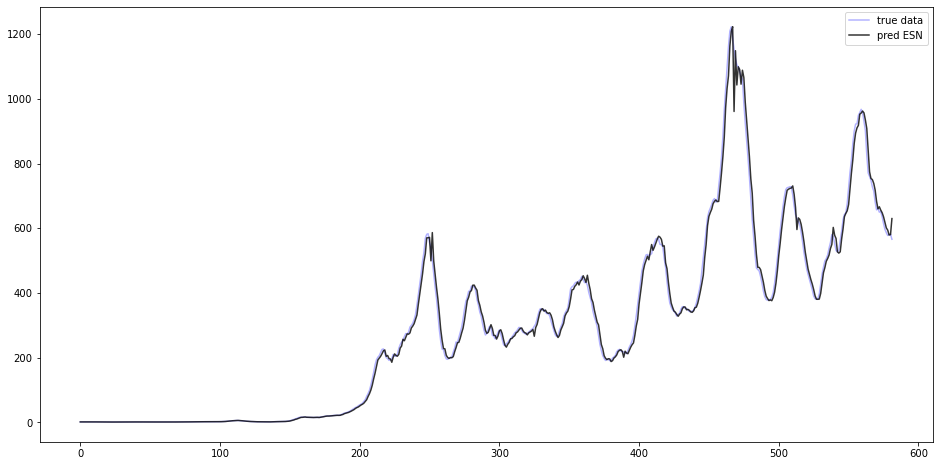

input true_values shape:  (582,)
input pred_values shape:  (582,)
output true_values_abs shape:  (582,)
output pred_values_abs shape:  (582,)


In [220]:
# Re-convert relative change values back to absolute values and plot validation target vs. prediction.
# Note: Use one-step prediction here with "teacher-forcing".
val_target_abs, val_pred_abs = rel_to_abs(val_target, val_pred, verbose=True)

### Stability and Reproducibility check

Run CNN/LSTM and ESN multiple time (say 10 times) and keep track of:

* prediction accuracy
* mean absolute error with "teacher-forcing"
* mean absolute erros in "free-float" modus

In [32]:
### Multiple run CNN/LSTM model

# set number of runs
n_run = 20

# initialize storage arrays for evaluation metrics
CNNLSTM_accuracy = np.zeros(n_run)
CNNLSTM_mae_teacher = np.zeros(n_run)
CNNLSTM_mae_free = np.zeros(n_run)

for k in range(n_run):
    # set up model
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
    #model.add(Dropout(0.5))
    model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
    #model.add(Dropout(0.5))
    model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

    # compile model (with constant lr)
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
    #model.summary()

    # train model
    history = model.fit(train_input, train_target_norm, epochs=7, batch_size=batch_size, shuffle=True, verbose=0, validation_data=(val_input, val_target_norm))

    ### Evaluate CNN/LSTM performance

    # Get model prediction and reverse min/max scaling
    val_pred = model.predict(val_input) * (train_max - train_min) + train_min

    # convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    ### 1 step prediction with "teacher-forcing"
    # Use predicted rel_chg for first step to get first absolute prediction. 
    # Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
    # from second predicted rel_chg.

    # as reference, need true absolute validation data
    val_true_abs = data_abs[-len(val_pred):]

    val_pred_abs = np.zeros(len(val_pred))
    for i in range(len(val_pred)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            val_pred_abs[i] = last_train_input_abs * (1 + val_pred[i])
        elif i>0:
            val_pred_abs[i] = val_true_abs[i-1] * (1 + val_pred[i])


    # store accuracy and mae (with "teacher forcing")
    CNNLSTM_accuracy[k] = np.round(sum((val_target >= 0) == (val_pred[:,0] >= 0)) / len(val_target), 3)
    CNNLSTM_mae_teacher[k] = np.round(sum(np.abs(val_true_abs - val_pred_abs)) / len(val_target), 1)


    ### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
    # "Free-floating" prediction over number of steps.

    # Set number of free-float steps
    n_steps = 10

    # Fix first val_input, but need all three dimensions (num samples, num timesteps, num features)
    temp_input = np.copy(val_input[0:1,:,0:1])

    # Initialize array for storing free-float predictions.
    val_pred_free = np.zeros(n_steps)

    # Loop over number of free-float steps
    for i in range (n_steps):

        # Get model prediction and reverse min/max scaling
        val_pred_free[i] = model.predict(temp_input)[0]

        # Shift last input series by one step and add prediction
        temp_input[0:1,:input_length-1,0:1] = temp_input[0:1,1:,0:1]
        temp_input[0,-1,0] = val_pred_free[i]

    # Reverse min/max scaling on free-float prediction
    val_pred_free_rescaled = val_pred_free * (train_max - train_min) + train_min

    # Convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    val_pred_free_abs = np.zeros(len(val_pred_free))
    for i in range(len(val_pred_free)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            val_pred_free_abs[i] = last_train_input_abs * (1 + val_pred_free_rescaled[i])
        elif i>0:
            val_pred_free_abs[i] = val_pred_free_abs[i-1] * (1 + val_pred_free_rescaled[i])

    # As reference, need true absolute validation data, starting from "last" absolute train input as basis,
    # then take n_steps
    val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]


    # store mae ("free-float" modus)
    CNNLSTM_mae_free[k] = np.round(sum(np.abs(val_true_abs - val_pred_free_abs)) / n_steps, 1)

In [33]:
### Multiple run ESN model

# set number of runs
n_run = 20

# initialize storage arrays for evaluation metrics
ESN_accuracy = np.zeros(n_run)
ESN_mae_teacher = np.zeros(n_run)
ESN_mae_free = np.zeros(n_run)

for k in range(n_run):
    
    # Opposed to CNN/LSTM - where we used input length 16d to predict 1d target -
    # here we use full training length to predict 1d target.
    # Note: In CNN/LSTM model we used rel_chg data with min/max scaling: val_target_norm

    ### But let's first focus on training data:
    # Train input for CNN/LSTM consists of 1500 samples of 16 timesteps each.
    # Extract the last timesteps of each sample to get the input for ESN.
    # Then have already min/max scaled rel_chg values:
    train_input_ESN = train_input[:,-1,0]

    # Train targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:

    ### prepare ESN
    # So we have one input feature (D=1) with T=1500 timesteps, t=1..T
    # Reservoir is set to N units (e.g. N=500)
    # And we have only one output feature (M=1)
    N = 500
    T = len(train_input_ESN)

    # initialize W_in from uniform distribution in [-1,1]
    W_in = np.random.uniform(low=-1.0, high=1.0, size=(N,1))

    ### initialize W_res

    # Sparsity is set to 0.2 and spectral_redius is set to 1.2, as in Tutorial.
    sparsity = 0.2
    spec_rad = 1.2

    # Need temporary matrix W_temp to implement sparsity manually
    W_temp = np.random.uniform(low=0, high=1, size=(500,500))
    W_sparse = W_temp <= sparsity

    # Then initialize W_full from uniform distribution in [-1,1]
    W_full = np.random.uniform(low=-1.0, high=1.0, size=(500,500))

    # Now apply sparsity to W
    W = W_sparse * W_full

    # get largest Eigenvalue of W
    ev_max = np.max(np.real(np.linalg.eigvals(W)))

    # finally set up W_res
    W_res = spec_rad * W / ev_max

    ### Get reservoir states X for all training input steps 1..T
    # Note: Use tanh as activation.

    # initialize X (N x T)
    X = np.zeros((N,T))

    for i in range(len(train_input_ESN)):
        # first step needs special treatment, since reservoir state is not yet initialized
        if i == 0:
            X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i])
        elif i > 0:
            X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i] + np.reshape(np.matmul(W_res, X[:,i-1]),(N,1)))

    ### Get output weights W_out from closed form solution

    # first need pseudo-inverse of X, since X is not a square matrix
    X_inv = np.linalg.pinv(X)

    # then need Y, as desired training outputs (= training targets, min/max scaled rel_chg values)
    Y = np.reshape(train_target_norm, (1,T))

    # then get output weights
    W_out = np.matmul(Y, X_inv)

    ### prediction and evaluation of ESN

    # Validation targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:

    # Prepare validation inputs by applying min/max scaling on rel_chg data
    input_rel_chg_norm = (data_rel_chg - train_min) / (train_max - train_min)

    ### Get reservoir states X for all validation input steps 1..T (loop i) for all validation targets (loop j)
    # Note: Use tanh as activation.

    # Initialize Y_pred to store predictions on validation input
    Y_pred = np.zeros(len(val_target_norm))

    for j in range(len(val_target_norm)):

        # Get current validation inputs.
        # Remember: Last 284 values are validation targets, as in CNN/LSTM example.
        # We want to have input length T=1500d, as in training of ESN, as a sliding window
        val_input_temp = input_rel_chg_norm[input_length+j : input_length+T+j]

        # initialize X_temp for current target (N x T)
        X_temp = np.zeros((N,T))

        for i in range(T):

            # first step needs special treatment, since reservoir state is not yet initialized
            if i == 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
            elif i > 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

        # get predicted output from trained W_out and last reservoir state
        Y_pred[j] = np.matmul(W_out, X_temp[:,-1])

    # reverse min/max scaling for predictions
    Y_pred_rescaled = Y_pred * (train_max - train_min) + train_min

    # convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(Y_pred) + 1)]

    ### 1 step prediction with "teacher-forcing"
    # Use predicted rel_chg for first step to get first absolute prediction. 
    # Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
    # from second predicted rel_chg.

    # as reference, get true absolute validation data
    Y_true_abs = data_abs[-len(Y_pred):]

    Y_pred_abs = np.zeros(len(Y_pred))
    for i in range(len(Y_pred)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            Y_pred_abs[i] = last_train_input_abs * (1 + Y_pred_rescaled[i])
        elif i>0:
            Y_pred_abs[i] = Y_true_abs[i-1] * (1 + Y_pred_rescaled[i])


    # store accuracy and mae (with "teacher forcing")
    ESN_accuracy[k] = np.round(sum((val_target >= 0) == (Y_pred_rescaled >= 0)) / len(val_target), 3)
    ESN_mae_teacher[k] = np.round(sum(np.abs(Y_true_abs - Y_pred_abs)) / len(val_target), 1)


    ### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
    # "Free-floating" prediction over number of steps.

    # Set number of free-float steps
    n_steps = 10

    # Fix first val_input
    val_input_temp = np.copy(input_rel_chg_norm[input_length : input_length+T])

    # Initialize array for storing free-float predictions
    Y_pred_free = np.zeros(n_steps)

    ### Get reservoir states X for all validation input steps 1..T (loop i) for all n_steps validation targets (loop j)
    # Note: Use tanh as activation.

    for j in range(n_steps):

        # initialize X_temp for current target (N x T)
        X_temp = np.zeros((N,T))

        for i in range(T):

            # first step needs special treatment, since reservoir state is not yet initialized
            if i == 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
            elif i > 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

        # get predicted output from trained W_out and last reservoir state
        Y_pred_free[j] = np.matmul(W_out, X_temp[:,-1])

        # Shift last input series by one step and add prediction
        val_input_temp[:T-1] = val_input_temp[1:]
        val_input_temp[-1] = Y_pred_free[j]

       # As reference, need true absolute validation data, starting from "last" absolute train input as basis,
    # then take n_steps
    val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]

    # Reverse min/max scaling on free-float prediction
    Y_pred_free_rescaled = Y_pred_free * (train_max - train_min) + train_min

    # Convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    Y_pred_free_abs = np.zeros(len(Y_pred_free))
    for i in range(n_steps):
        # first value needs to hook on last_train_input_abs
        if i==0:
            Y_pred_free_abs[i] = last_train_input_abs * (1 + Y_pred_free_rescaled[i])
        elif i>0:
            Y_pred_free_abs[i] = Y_pred_free_abs[i-1] * (1 + Y_pred_free_rescaled[i])


    # store mae ("free-float" modus)
    ESN_mae_free[k] = np.round(sum(np.abs(val_true_abs - Y_pred_free_abs)) / n_steps, 1)

CNN-LSTM metrics
accuracy:  [0.465 0.468 0.412 0.539 0.451 0.444 0.588 0.482 0.447 0.479]
mae_teacher:  [ 9.6 13.  10.7  9.2  9.5 13.5 10.   8.8  9.3 10.1]
mae_free:  [23.5 20.4 26.  26.6 14.1 27.5 76.4 19.1 18.4 46.1]

ESN metrics
accuracy:  [0.514 0.507 0.525 0.542 0.549 0.542 0.518 0.507 0.542 0.528]
mae_teacher:  [10.9 10.6 11.2  9.8 10.8 10.3 11.  10.5 11.2 10.1]
mae_free:  [35.6 16.9 47.4 38.9 35.6 29.6 47.6 44.1 17.2 15.2]


[Text(1, 0, 'CNN/LSTM'), Text(2, 0, 'ESN')]

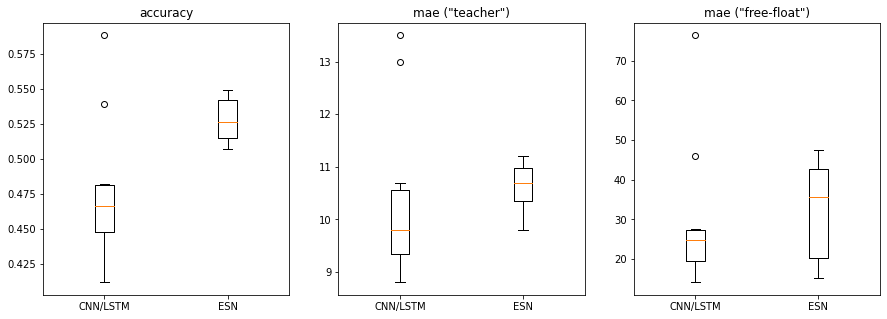

In [31]:
### Evaluate performance metrics for multiple runs (n_run) of CNN/LSTM model

## print raw arrays

print("CNN-LSTM metrics")
print("================")
print("accuracy: ", CNNLSTM_accuracy)
print("mae_teacher: ", CNNLSTM_mae_teacher)
print("mae_free: ", CNNLSTM_mae_free)
print("\nESN metrics")
print("================")
print("accuracy: ", ESN_accuracy)
print("mae_teacher: ", ESN_mae_teacher)
print("mae_free: ", ESN_mae_free)

# stack arrays to show as preparation for joint boxplot
joint_accuracy = np.stack((CNNLSTM_accuracy, ESN_accuracy), axis=1)
joint_mae_teacher = np.stack((CNNLSTM_mae_teacher, ESN_mae_teacher), axis=1)
joint_mae_free = np.stack((CNNLSTM_mae_free, ESN_mae_free), axis=1)

# Boxplots:
# Shows median as orange line, rectangle box specifies Q1 and Q3 (25% and 75% percentile), defining IQR
# and whiskers show Q1 - 1.5*IQR and Q3 + 1.5*IQR, circles mark outliers.
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].set_title('accuracy')
axes[0].boxplot(joint_accuracy)
axes[0].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[1].set_title('mae ("teacher")')
axes[1].boxplot(joint_mae_teacher)
axes[1].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[2].set_title('mae ("free-float")')
axes[2].boxplot(joint_mae_free)
axes[2].set_xticklabels(['CNN/LSTM', 'ESN'])

CNN-LSTM metrics
accuracy:  [0.437 0.577 0.521 0.44  0.56  0.479 0.525 0.44  0.504 0.486 0.451 0.405
 0.525 0.556 0.454 0.57  0.444 0.549 0.468 0.563]
mae_teacher:  [11.5  8.8  8.7  9.8 10.5 10.7  9.4  9.8 10.1  9.2  9.9  9.2  9.5  9.3
 10.1 10.6  9.6  9.1  9.5  8.7]
mae_free:  [28.8 37.4 47.6 18.7 28.7 17.6 29.5 22.3 37.9 18.3  7.1 24.5 16.8 20.2
 21.  24.3 20.9 28.6 16.8 39.6]

ESN metrics
accuracy:  [0.56  0.57  0.563 0.482 0.489 0.563 0.514 0.532 0.535 0.549 0.532 0.528
 0.542 0.532 0.57  0.518 0.504 0.553 0.535 0.496]
mae_teacher:  [ 9.5  9.8 10.7 11.  11.3  9.5 10.9 11.4 10.4 10.  10.4 10.9 11.4  9.5
 10.8 11.5 10.7 10.5 10.2 11.9]
mae_free:  [30.5 42.2 13.3 30.9 25.2 31.8 41.4 17.7 37.2 23.1 47.2 57.1 40.3 43.3
 47.7 57.6 12.4 18.9 19.1 16.2]


[Text(1, 0, 'CNN/LSTM'), Text(2, 0, 'ESN')]

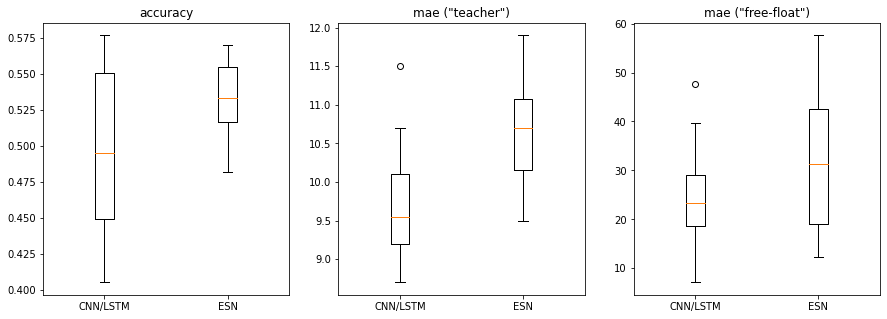

In [34]:
### Evaluate performance metrics for multiple runs (n_run) of CNN/LSTM model

## print raw arrays

print("CNN-LSTM metrics")
print("================")
print("accuracy: ", CNNLSTM_accuracy)
print("mae_teacher: ", CNNLSTM_mae_teacher)
print("mae_free: ", CNNLSTM_mae_free)
print("\nESN metrics")
print("================")
print("accuracy: ", ESN_accuracy)
print("mae_teacher: ", ESN_mae_teacher)
print("mae_free: ", ESN_mae_free)

# stack arrays to show as preparation for joint boxplot
joint_accuracy = np.stack((CNNLSTM_accuracy, ESN_accuracy), axis=1)
joint_mae_teacher = np.stack((CNNLSTM_mae_teacher, ESN_mae_teacher), axis=1)
joint_mae_free = np.stack((CNNLSTM_mae_free, ESN_mae_free), axis=1)

# Boxplots:
# Shows median as orange line, rectangle box specifies Q1 and Q3 (25% and 75% percentile), defining IQR.
# Whiskers reach to maximum/minimum observation in case we have NO outliers. 
# Observations below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are defined to be "outliers" and marked as circles.
# When we have outliers, whiskers only reach to maximum/minimum observations EXCLUDING outliers.
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].set_title('accuracy')
axes[0].boxplot(joint_accuracy)
axes[0].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[1].set_title('mae ("teacher")')
axes[1].boxplot(joint_mae_teacher)
axes[1].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[2].set_title('mae ("free-float")')
axes[2].boxplot(joint_mae_free)
axes[2].set_xticklabels(['CNN/LSTM', 'ESN'])